## 0. Import and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
from pprint import pprint

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'object'
}   

# 데이터 경로 맞춰주세요!
TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/test_data.csv'
TRAIN_TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/train_test_data.csv'

train_df = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

train_test_df = pd.read_csv(TRAIN_TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_test_df = train_test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 11.2 s, sys: 1.15 s, total: 12.3 s
Wall time: 12.3 s


In [3]:
from collections import defaultdict

df = train_test_df.copy()
test_prob_count = defaultdict(set)
for test_id, assessmentItemID in zip(df["testId"], df["assessmentItemID"]):
    test_prob_count[test_id].add(assessmentItemID[-3:])
test_prob_count = {key: len(value) for key, value in test_prob_count.items()}

In [22]:
df = train_test_df.copy()

user_current_test = dict()
time_elapsed = []
test_start_idx = 0
df = df.astype({'Timestamp': 'datetime64[ns]'})

for idx, (cur_user_id, next_user_id, cur_test_id, cur_timestamp, next_timestamp) in enumerate(zip(df["userID"], df["userID"].shift(-1), df["testId"], df["Timestamp"], df["Timestamp"].shift(-1))):
    if cur_user_id != next_user_id: # 만약 사용자가 바뀌는 타이밍이라면, 
        time_elapsed.append(int(sum(time_elapsed[test_start_idx - idx:]) / len(time_elapsed[test_start_idx - idx:]))) # 이전까지 문제를 풀때 걸린 시간의 평균을 구합니다.
        test_start_idx = idx
        user_current_test = dict() # dict를 새로 선언해줍니다. 
        continue
        
    if cur_test_id not in user_current_test: # 만약 사용자가 지금 풀고 있는 문제 목록에 없는 거라면,
        user_current_test[cur_test_id] = test_prob_count[cur_test_id] - 1 # 문제 목록에 추가해주면서, 남아있는 문항수도 추가합니다. (-1을 하는 이유는 현재 row를 확인했을 때 한문제를 푼거랑 동일하니까요!)
        time_elapsed.append((next_timestamp - cur_timestamp).total_seconds()) # 지금 푸는 문제와 다음 문제 사이의 시간 간격을 기록합니다.
        
    else: # 만약 사용자가 지금 풀고 있는 문제라면,
        user_current_test[cur_test_id] -= 1 # 해당 시험지의 남아있는 문항수를 하나 빼줍니다.

        if user_current_test[cur_test_id] == 0: # 근데 확인해보니 해당 시험지에 대해 이미 사용자가 다 풀어버려서 남아있는 문항수가 0이라면,
            del user_current_test[cur_test_id] # 현재 풀고 있는 문제에서 제거하기 위해 test_id에 해당하는 key값을 삭제합니다.

            if len(user_current_test.keys()) == 0: # 확인해보니 아예 사용자가 풀어야할 시험지가 하나도 없다면,
                time_elapsed.append(int(sum(time_elapsed[test_start_idx - idx:]) / len(time_elapsed[test_start_idx - idx:]))) # 이전까지 문제를 풀때 걸린 시간의 평균을 구합니다.
                test_start_idx = idx
            
            else: # 아직 풀어야할 시험지가 남아있다면 시험을 보고 있는 중이므로,
                time_elapsed.append((next_timestamp - cur_timestamp).total_seconds()) # 지금 푸는 문제와 다음 문제 사이의 시간 간격을 기록합니다.
        
        else:
            time_elapsed.append((next_timestamp - cur_timestamp).total_seconds()) # 지금 푸는 문제와 다음 문제 사이의 시간 간격을 기록합니다.
        
        
time_elapsed = pd.DataFrame(time_elapsed, columns=['time_elapsed'])
time_elapsed.count()

time_elapsed    2525956
dtype: int64

In [23]:
time_elapsed.describe()

,time_elapsed
count,2.525956e+06
mean,1.984324e+02
std,5.783753e+03
min,0.000000e+00
25%,1.200000e+01
50%,3.000000e+01
75%,6.900000e+01
max,1.808847e+06


In [24]:
def funck(x):
    if x > 300:
        x = 300
    return x
time_elapsed["time_elapsed"].apply(funck).describe()

count    2.525956e+06
mean     5.811182e+01
std      7.382628e+01
min      0.000000e+00
25%      1.200000e+01
50%      3.000000e+01
75%      6.900000e+01
max      3.000000e+02
Name: time_elapsed, dtype: float64

In [5]:
train_df.memory_usage(deep=True) # userId랑 KnowledgeTag는 int16으로 해서 Memory 사용량을 확 줄이자

Index                     128
userID                4533172
assessmentItemID    151861262
testId              151861262
answerCode            2266586
Timestamp            18132688
KnowledgeTag        137968342
dtype: int64

## 1. 기본적인 내용 파악
정리하면,   
- `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
- `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
- `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
- `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
- `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
- `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   

특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [6]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      object        
dtypes: datetime64[ns](1), int16(1), int8(1), object(3)
memory usage: 75.7+ MB


In [8]:
train_df.describe(include='all')
# 우선 시간데이터는 2019-12말 부터 ~ 2020-12말 까지 

ipykernel_launcher:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
count,2.266586e+06,2266586,2266586,2.266586e+06,2266586,2266586
unique,NaN,9454,1537,NaN,2076774,912
top,NaN,A090014002,A080000128,NaN,2020-10-15 08:59:56,7597
freq,NaN,454,3960,NaN,7,12892
first,NaN,NaN,NaN,NaN,2019-12-31 15:08:01,NaN
last,NaN,NaN,NaN,NaN,2020-12-29 16:46:21,NaN
mean,2.087687e+03,NaN,NaN,6.543784e-01,NaN,NaN
std,1.589365e+03,NaN,NaN,4.755706e-01,NaN,NaN
min,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN
25%,8.000000e+02,NaN,NaN,0.000000e+00,NaN,NaN


### Test Dataset에 대한 분석도 동시에 해보자

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260114 entries, 0 to 260113
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userID            260114 non-null  int16         
 1   assessmentItemID  260114 non-null  object        
 2   testId            260114 non-null  object        
 3   answerCode        260114 non-null  int8          
 4   Timestamp         260114 non-null  datetime64[ns]
 5   KnowledgeTag      260114 non-null  object        
dtypes: datetime64[ns](1), int16(1), int8(1), object(3)
memory usage: 8.7+ MB


In [10]:
test_df.describe(include="all")
# test도 마찬가지로 시간은 2019년 말부터 2020년 말까지

ipykernel_launcher:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
count,260114.000000,260114,260114,260114.000000,260114,260114
unique,NaN,9454,1537,NaN,256622,912
top,NaN,A090001007,A080000128,NaN,2020-10-23 08:34:49,7597
freq,NaN,53,440,NaN,3,1458
first,NaN,NaN,NaN,NaN,2019-12-31 23:43:18,NaN
last,NaN,NaN,NaN,NaN,2020-12-29 16:44:10,NaN
mean,2042.981800,NaN,NaN,0.652172,NaN,NaN
std,1551.399824,NaN,NaN,0.482250,NaN,NaN
min,3.000000,NaN,NaN,-1.000000,NaN,NaN
25%,802.000000,NaN,NaN,0.000000,NaN,NaN


In [11]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {train_df.userID.nunique()}
assessmentItemID : {train_df.assessmentItemID.nunique()}
testID           : {train_df.testId.nunique()}
mean answer rate : {train_df.answerCode.sum() / train_df.shape[0] * 100:.2f}%
KnowledgeTag     : {train_df.KnowledgeTag.nunique()}
{'-'*26}""")

# train에 결측치는 없네요
print(f"if there is Nan in train_df: {train_df.isnull().values.any()}\n")


print(f"""--- BASIC INFORMATIONS ---
userID           : {test_df.userID.nunique()}
assessmentItemID : {test_df.assessmentItemID.nunique()}
testID           : {test_df.testId.nunique()}
mean answer rate : {test_df.answerCode.loc[test_df.answerCode != -1].sum() / test_df.answerCode.loc[test_df.answerCode != -1].count() * 100:.2f}%
KnowledgeTag     : {test_df.KnowledgeTag.nunique()}
{'-'*26}""")

# test에도 마찬가지로 결측치는 없네요
print(f"if there is Nan in test_df: {test_df.isnull().values.any()}")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------
if there is Nan in train_df: False

--- BASIC INFORMATIONS ---
userID           : 744
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.69%
KnowledgeTag     : 912
--------------------------
if there is Nan in test_df: False


In [12]:
print((test_df.answerCode == -1).sum())
print(test_df.userID.nunique())

# test dataset 중 answercode가 "-1"인 행은 총 744개, 예측해야하는 user의 수도 744개

744
744


## test에서 마지막에 예측해야하는 시험지가 같은 유저가 train에는 몇명 존재할까?
 - 이 친구들(847)이면 사실 꽤 많은 수치이긴 한데,, 너무 cheating 같아서 ㅜ
 - 근데 이 친구들을 잘게 쪼개기는 또 어려운 것이 사실, 단일 fold로만 존재할 수 밖에 없넹

In [11]:
test_must_prediction = test_df.testId[test_df["answerCode"] == -1]
unique_test_must_prediction = test_must_prediction.unique()

In [17]:
prev_user = train_df["userID"][0]
result = []
for cur_user, cur_test in zip(train_df["userID"], train_df["testId"]):
    if cur_user != prev_user:
        if cur_test in unique_test_must_prediction:
            result.append(1)
        else:
            result.append(0)

        prev_user = cur_user

sum(result)

847

### assessmentItemID 번호 분석
사용자가 푼 문항의 일련번호로, 총 10자리로 구성되어있으며 규칙은,

    1. 첫 자리는 항상 알파벳 'A'
    2. 그 다음 6자리는 시험지 번호
    3. 마지막 3자리는 시험지 내 문항의 번호 -> 근데 최대 해봐야 한 시험지당 최대 13문제 밖에 안된다!

In [14]:
# 첫 번째 단어는 only A로만 존재 -> 특성의 가치는 없다.
train_df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

In [15]:
# 1~7번째 자리의 숫자는 testId의 번호와 일치(1~3 + 7~9)
# 정확하게 2266586개가 딱 떨어지는 것을 보니 모든 Row에 적용되는 것
sum(train_df['assessmentItemID'].apply(lambda x: x[1:7]) == train_df['testId'].apply(lambda x: x[1:4]+x[7:]))

2266586

In [16]:
# 마지막 3자리의 역할은?
# 엥..? 한 시험지에 많아봤자 최대 13문제 밖에 안되네?
print(train_df['assessmentItemID'].apply(lambda x: x[-3:]).unique())
print(test_df['assessmentItemID'].apply(lambda x: x[-3:]).unique())

['001' '002' '003' '004' '005' '007' '006' '008' '009' '010' '011' '012'
 '013']
['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013']


### testId 번호 분석
사용자가 푼 시험지의 일련번호로, 총 10자리로 구성되어있으며 규칙은,

    1. 첫 자리는 항상 알파벳 'A'
    2. 그 다음 9자리 중 앞의 3자리와 끝의 3자리가 시험지 번호
        - 앞의 3자리의 구성은 '010' ~ '090' 총 9가지 종류가 있다.
    3. 가운데 3자리는 모두 000

In [17]:
# 첫 번째 단어는 only A로만 존재 -> 특성의 가치는 없다.
train_df['testId'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

In [18]:
# 앞의 3자리의 구성은 '010' ~ '090' 총 9가지 종류가 있다
train_df['testId'].apply(lambda x: x[1:4]).unique() 

array(['060', '080', '020', '040', '090', '010', '030', '050', '070'],
      dtype=object)

In [7]:
# 가운데 3자리는 모두 '000'으로 구성되어 있으므로 아무런 의미는 없다.
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

### 그러면 시험지 별로 문제 수가 어떻게 분포되어 있는지 한번 확인해봅시다.
    1. 특정 학생이 같은 시험지를 여러번 풀 수 있다? -> True
    2. 시험지가 같으면 학생이 푸는 문제수는 무조건 동일할까?
    3. testId가 비슷한 애들끼리 서로 시험을 볼 것 같은데 어떻게 생각해? (만약 1-9가 학년별 구분이라면!)
    4. test_id_pre와 정답률 사이의 상관관계를 한번 찾아보자

In [13]:
def assessmentItemID2item(x):
    return x[-3:]

In [14]:
def assessmentItemID2test(x):
    return x[1:-3]

In [15]:
def test2test_pre(x):
    return x[:3]

In [16]:
def test2test_post(x):
    return x[3:]

In [17]:
train_df['problem_number'] = train_df.assessmentItemID.map(assessmentItemID2item)
test_df['problem_number'] = test_df.assessmentItemID.map(assessmentItemID2item)
train_df['test'] = train_df.assessmentItemID.map(assessmentItemID2test)
test_df['test'] = test_df.assessmentItemID.map(assessmentItemID2test)
train_df['test_pre'] = train_df.test.map(test2test_pre)
test_df['test_pre'] = test_df.test.map(test2test_pre)
train_df['test_post'] = train_df.test.map(test2test_post)
test_df['test_post'] = test_df.test.map(test2test_post)

train_df.drop('test', axis=1, inplace=True)
test_df.drop('test', axis=1, inplace=True)

train_df.head(20)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,test_pre,test_post
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,001,060,001
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,002,060,001
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,003,060,001
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,004,060,001
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,005,060,001
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,007,060,001
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,001,060,003
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,002,060,003
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,003,060,003
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,004,060,003


In [18]:
train_df.describe(include="all")

ipykernel_launcher:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,test_pre,test_post
count,2.266586e+06,2266586,2266586,2.266586e+06,2266586,2266586,2266586,2266586,2266586
unique,NaN,9454,1537,NaN,2076774,912,13,9,198
top,NaN,A090014002,A080000128,NaN,2020-10-15 08:59:56,7597,001,070,017
freq,NaN,454,3960,NaN,7,12892,371755,279164,17739
first,NaN,NaN,NaN,NaN,2019-12-31 15:08:01,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2020-12-29 16:46:21,NaN,NaN,NaN,NaN
mean,2.087687e+03,NaN,NaN,6.543784e-01,NaN,NaN,NaN,NaN,NaN
std,1.589365e+03,NaN,NaN,4.755706e-01,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,8.000000e+02,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [19]:
# 근데 최대 종류의 수가 3개인가..? 그 이상은 못푸는거야?
# 학생수가 6698이니까 딱 맞긴한데...?
user_test_group = train_df.groupby("userID").agg({"test_pre": "nunique"})
print(user_test_group.value_counts())

# test dataset도 그러한지 확인해보자, test dataset도 딱 정해져있네,,,?
user_test_group = test_df.groupby("userID").agg({"test_pre": "nunique"})
print(user_test_group.value_counts())

test_pre
3           4458
2           2138
1            102
dtype: int64
test_pre
3           508
2           227
1             9
dtype: int64


In [20]:
# 그러면 시험지를 푸는 조합이 어느정도 정해져있을 수 있다!
# 어떤 조합들이 있는지 한번 살펴보자 -> 1,2,3 다합쳐서 총 129가지 조합이 발생
user_test_group = train_df.groupby("userID")

train_testid_combination = dict()

for key, group in user_test_group:
    test_pres = np.sort(group.test_pre.unique())
    key = ''
    for test_pre in test_pres:
        key += test_pre[1]

    if key in train_testid_combination:
        train_testid_combination[key] += 1
    else:
        train_testid_combination[key] = 1

print(len(train_testid_combination.keys()))
pprint(sorted(train_testid_combination.items(), key=(lambda x:x[1]), reverse=True))

        

129
[('345', 143),
 ('34', 137),
 ('45', 136),
 ('24', 120),
 ('36', 107),
 ('134', 103),
 ('234', 102),
 ('145', 101),
 ('124', 100),
 ('23', 100),
 ('46', 98),
 ('246', 95),
 ('456', 95),
 ('356', 94),
 ('346', 94),
 ('35', 92),
 ('25', 92),
 ('245', 92),
 ('236', 91),
 ('13', 90),
 ('14', 90),
 ('235', 89),
 ('256', 86),
 ('123', 83),
 ('146', 83),
 ('135', 82),
 ('47', 79),
 ('16', 79),
 ('126', 79),
 ('56', 78),
 ('156', 77),
 ('125', 75),
 ('347', 74),
 ('348', 74),
 ('247', 74),
 ('147', 71),
 ('458', 70),
 ('37', 68),
 ('248', 68),
 ('15', 68),
 ('137', 68),
 ('157', 68),
 ('136', 68),
 ('457', 67),
 ('267', 66),
 ('358', 66),
 ('12', 65),
 ('468', 65),
 ('357', 64),
 ('268', 63),
 ('237', 62),
 ('26', 62),
 ('238', 62),
 ('27', 61),
 ('367', 60),
 ('48', 59),
 ('127', 58),
 ('467', 58),
 ('368', 58),
 ('567', 58),
 ('148', 56),
 ('568', 53),
 ('158', 52),
 ('128', 52),
 ('168', 51),
 ('257', 49),
 ('258', 47),
 ('167', 46),
 ('58', 45),
 ('138', 45),
 ('68', 44),
 ('38', 44),


In [21]:
user_test_group = test_df.groupby("userID")

test_testid_combination = dict()

for key, group in user_test_group:
    test_pres = np.sort(group.test_pre.unique())
    key = ''
    for test_pre in test_pres:
        key += test_pre[1]

    if key in test_testid_combination:
        test_testid_combination[key] += 1
    else:
        test_testid_combination[key] = 1

print(len(test_testid_combination.keys()))
pprint(sorted(test_testid_combination.items(), key=(lambda x:x[1]), reverse=True))


116
[('347', 18),
 ('46', 17),
 ('345', 17),
 ('24', 15),
 ('346', 15),
 ('135', 14),
 ('123', 14),
 ('234', 13),
 ('15', 13),
 ('458', 12),
 ('248', 12),
 ('13', 12),
 ('45', 12),
 ('14', 11),
 ('356', 11),
 ('134', 11),
 ('245', 11),
 ('124', 11),
 ('367', 11),
 ('47', 10),
 ('468', 10),
 ('125', 10),
 ('34', 10),
 ('147', 9),
 ('247', 9),
 ('27', 9),
 ('167', 9),
 ('37', 9),
 ('137', 9),
 ('236', 9),
 ('16', 9),
 ('25', 8),
 ('35', 8),
 ('58', 8),
 ('56', 8),
 ('457', 8),
 ('567', 8),
 ('158', 8),
 ('256', 8),
 ('23', 8),
 ('267', 7),
 ('26', 7),
 ('258', 7),
 ('357', 7),
 ('145', 7),
 ('146', 7),
 ('358', 7),
 ('467', 7),
 ('67', 7),
 ('268', 7),
 ('238', 7),
 ('246', 7),
 ('138', 7),
 ('126', 7),
 ('235', 7),
 ('257', 6),
 ('569', 6),
 ('378', 6),
 ('128', 6),
 ('348', 6),
 ('578', 6),
 ('156', 6),
 ('148', 6),
 ('36', 6),
 ('249', 5),
 ('456', 5),
 ('18', 5),
 ('136', 5),
 ('38', 5),
 ('157', 5),
 ('48', 5),
 ('237', 5),
 ('568', 5),
 ('359', 4),
 ('678', 4),
 ('469', 4),
 ('68',

In [24]:
# 사실,, 나는 합친 데이터를 쓰고 있어서 무조건 조합이 걸릴 수 밖에 없긴 하네 ㅋㅋ
user_test_group = train_df.groupby("userID")["test_pre"].unique()
user_test_group = user_test_group.reset_index().rename(columns={"index": "userID"})

def foo(x):
    comb = ''
    x = sorted(x)
    for test in x:
        comb += test[1]
    return comb
user_test_group["test_pre_comb"] = user_test_group["test_pre"].apply(foo)
user_test_dict = {key: value for key, value in zip(user_test_group["userID"], user_test_group["test_pre_comb"])}

user_test_dict

{0: '268',
 1: '49',
 2: '35',
 5: '168',
 6: '34',
 7: '259',
 8: '167',
 9: '47',
 10: '46',
 11: '347',
 12: '279',
 14: '127',
 15: '237',
 16: '12',
 18: '134',
 19: '123',
 20: '356',
 21: '235',
 22: '278',
 23: '278',
 24: '789',
 25: '279',
 27: '345',
 28: '35',
 30: '17',
 31: '479',
 32: '679',
 33: '457',
 34: '78',
 35: '146',
 36: '67',
 37: '459',
 38: '236',
 39: '79',
 40: '47',
 41: '267',
 42: '158',
 43: '235',
 44: '124',
 46: '127',
 47: '123',
 48: '468',
 49: '356',
 50: '357',
 51: '458',
 52: '125',
 54: '18',
 55: '459',
 56: '146',
 57: '347',
 59: '167',
 60: '26',
 61: '178',
 62: '168',
 63: '158',
 65: '35',
 66: '346',
 67: '16',
 68: '58',
 69: '27',
 70: '139',
 71: '234',
 72: '37',
 73: '134',
 74: '12',
 75: '278',
 77: '356',
 78: '236',
 80: '56',
 81: '12',
 82: '56',
 83: '27',
 84: '234',
 85: '346',
 86: '47',
 87: '358',
 88: '246',
 89: '134',
 90: '357',
 91: '134',
 92: '25',
 93: '348',
 95: '237',
 96: '578',
 97: '239',
 98: '13',
 99

In [81]:
# 확실히 1~9로 가면서 정답률이 점점 떨어지는 경향성이 확실히 있다.
test_acc = train_df.groupby("test_pre").agg({"answerCode": "mean"})
test_acc

,answerCode
test_pre,
010,0.800876
020,0.737593
030,0.702238
040,0.684056
050,0.658208
060,0.709232
070,0.521876
080,0.502598
090,0.449948


In [82]:
# 확실히 1~9로 가면서 정답률이 점점 떨어지는 경향성이 확실히 있다.
test_acc = test_df.groupby("test_pre").agg({"answerCode": lambda x: sum(x==1) / sum(x!=-1)})
test_acc

,answerCode
test_pre,
010,0.808660
020,0.742017
030,0.701956
040,0.649547
050,0.667136
060,0.737582
070,0.520867
080,0.483709
090,0.500817


## 1.2 기술 통계량 분석

In [18]:
def percentile(s):
    return np.sum(s) / len(s)

### 사용자 분석

In [26]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.rename(columns={"assessmentItemID": "assessmentItemID_count", "answerCode": "answerCode_avg"}, inplace=True)
stu_groupby

,assessmentItemID_count,answerCode_avg
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
5,833,0.795918
6,921,0.442997
...,...,...
7436,15,0.466667
7437,16,0.375000
7438,16,0.750000


In [27]:
stu_groupby.describe()

,assessmentItemID_count,answerCode_avg
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


#### 사용자 문항 개수 도수분포표

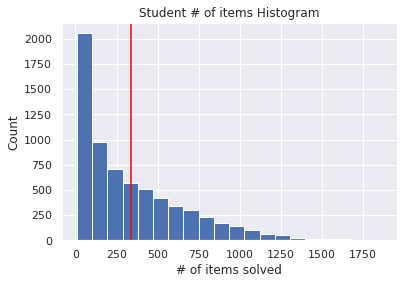

In [28]:
fig, ax = plt.subplots()
stu_groupby['assessmentItemID_count'].hist(bins=20, ax=ax)
ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID_count'].mean(), color='red') # 338.397432
ax.grid(b=True)

#### 사용자 정답률 도수분포표

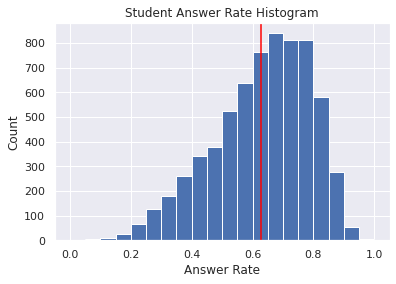

In [23]:
fig, ax = plt.subplots()
stu_groupby['answerCode_avg'].hist(bins=20)
ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode_avg'].mean(), color='red') # 0.628909
ax.grid(b=True)

### 문항 별 정답률 분석

In [29]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.rename(columns={"userID": "userID_count", "answerCode": "answerCode_avg"}, inplace=True)
prob_groupby

,userID_count,answerCode_avg
assessmentItemID,,
A010001001,317,0.930599
A010001002,317,0.958991
A010001003,317,0.905363
A010001004,317,0.949527
A010001005,317,0.886435
...,...,...
A090074002,45,0.444444
A090074003,45,0.577778
A090074004,45,0.333333


In [30]:
prob_groupby.describe()

,userID_count,answerCode_avg
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


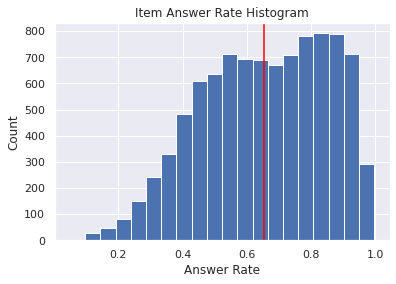

In [31]:
fig, ax = plt.subplots()
prob_groupby['answerCode_avg'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode_avg'].mean(), color='red')
ax.grid(b=True)

### 시험지 별 정답률 분석

In [32]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.rename(columns={"userID": "userID_count", "answerCode": "answerCode_avg"}, inplace=True)
test_groupby

,userID_count,answerCode_avg
testId,,
A010000001,1585,0.926183
A010000002,1550,0.931613
A010000003,1615,0.846440
A010000004,1540,0.883117
A010000005,1595,0.855172
...,...,...
A090000070,344,0.418605
A090000071,360,0.336111
A090000072,270,0.418519


In [33]:
test_groupby.describe()

,userID_count,answerCode_avg
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


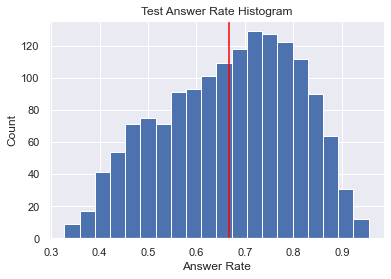

In [15]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

## 1.3 일반적인 EDA

### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

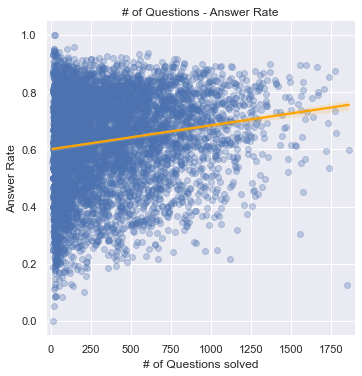

In [17]:
g = sns.lmplot(data=stu_groupby, x='assessmentItemID', y='answerCode',
              scatter_kws={'alpha':0.3}, line_kws={"color": "orange"})
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))
ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [18]:
print(f"Correlation between # of Tags being solved - Answer Rate: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.168


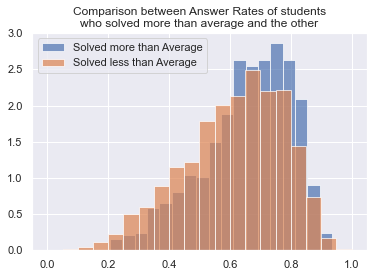

In [19]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average')
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average')
ax.legend()

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [20]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


Text(0.5, 1.0, '# of Tags Exposed - Answer Rate')

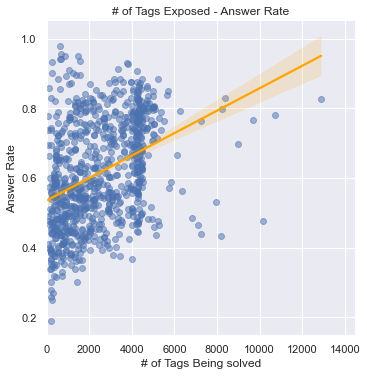

In [21]:
g = sns.lmplot(data=tag_groupby, x='userID', y='answerCode',
              scatter_kws={'alpha':0.5}, line_kws={"color": "orange"})
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))
ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')

In [22]:
print(f"Correlation between # of Tags being solved - Answer Rate: {tag_groupby.corr()['answerCode']['userID']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.376


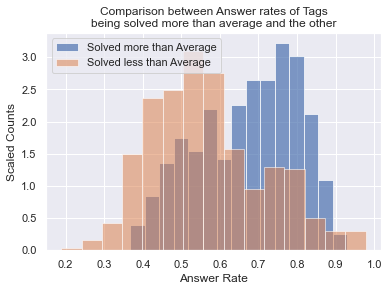

In [23]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')
tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

### 문항을 풀수록 실력이 늘어나는가?

In [24]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

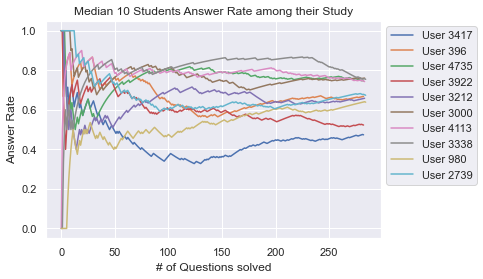

In [25]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

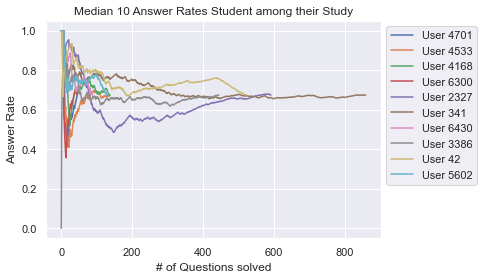

In [26]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [27]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

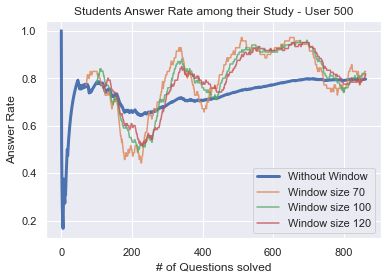

In [28]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

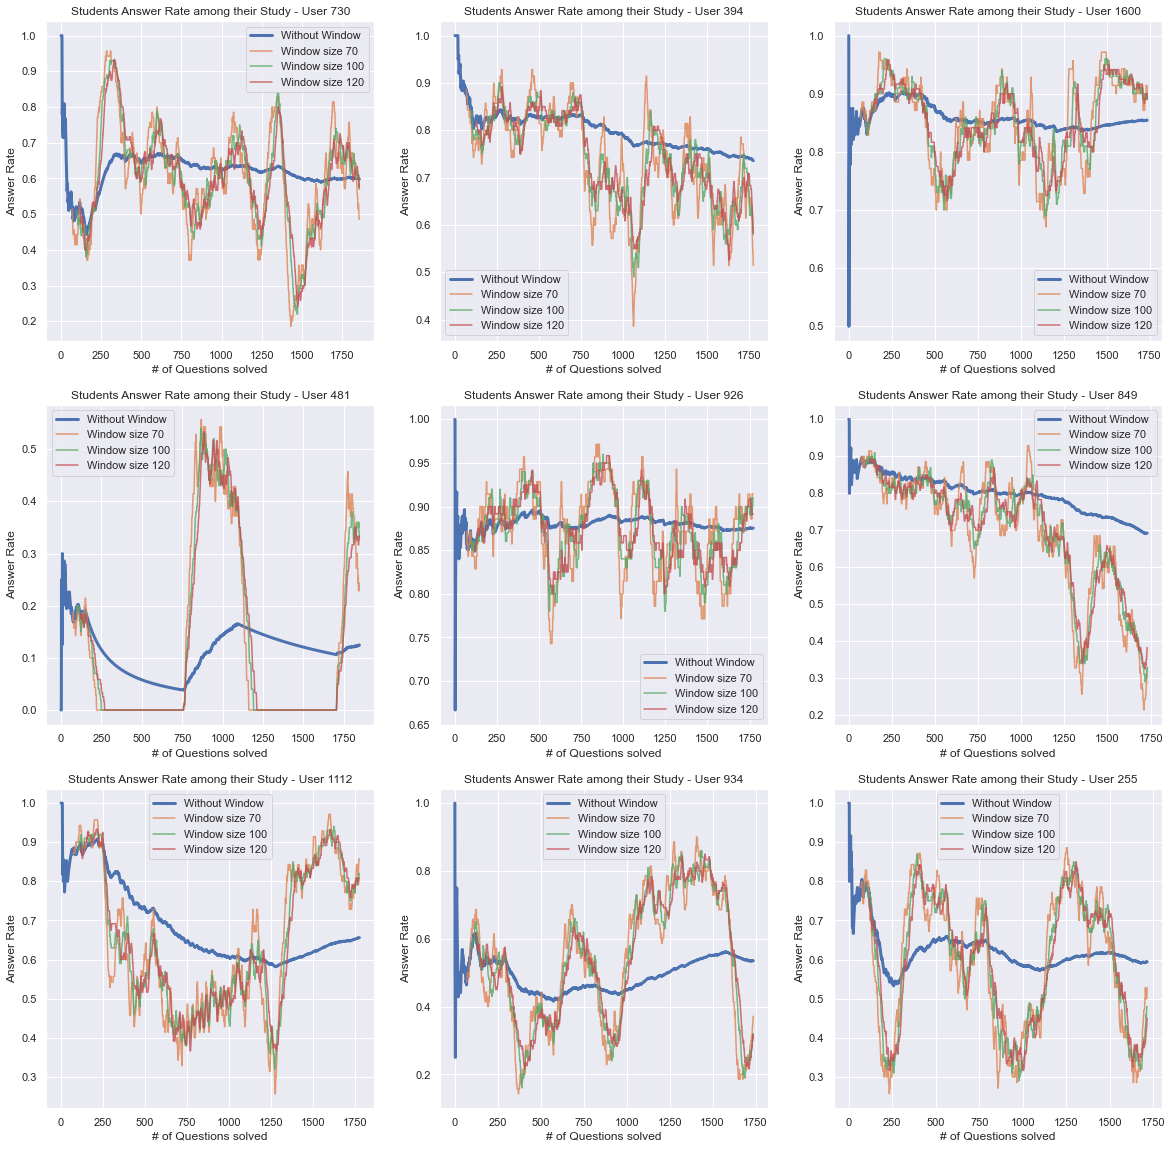

In [29]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [30]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

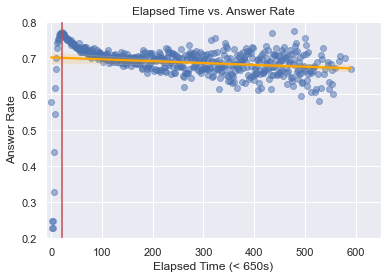

In [31]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

# 2. Daily Mission

### (a)
사실 위에서 그린 문항수-정답률 그래프는 큰 insight를 주지 못하는 것 같습니다. 같은 문항을 푼 학생들의 정답률은 당연히 상이하겠지만, 이 평균을 보는 것이 더 의미가 있을 것 같은데 아래처럼 보면 너무 점이 많아서 insight를 얻기 힘드네요.
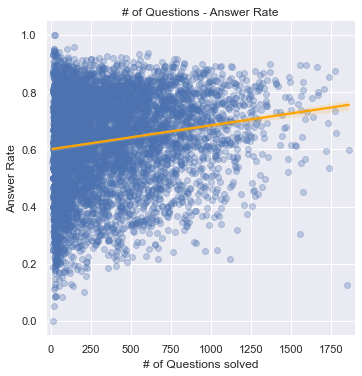

그러면 이번엔 같은 문항수를 푼 학생들이 있다면, 그 학생들의 평균을 찍어서 그래프를 그려봅시다. 가령 9문항을 푼 학생이 10명이라면, 그 학생들의 평균이 찍히도록 말이죠! 아래와 같은 형태이면 좋을 것 같습니다.
- **x-axis**: 사용자가 푼 문항의 수
- **y-axis**: 정답률
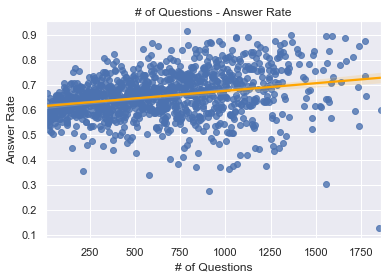

### (b)

그런데 위 그래프도... 사실 점이 너무 많습니다. 이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같네요. 예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내는 것처럼요.   
`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=500이었다면 아래와 같이 500개의 bin을 만들어서 그래프가 그려지도록 해주세요 :)    

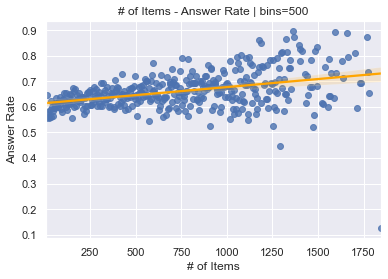

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

data = np.random.randn(5534, 4)
key = np.random.randint(1,129,size=(5534,1))
key = key.astype(str)
print(key)
data

for train_idx, test_idx in skf.split(data, key):
    print(train_idx)

[['70']
 ['35']
 ['63']
 ...
 ['8']
 ['58']
 ['45']]
[   0    3    4 ... 5529 5532 5533]
[   0    1    2 ... 5528 5530 5531]
[   1    2    3 ... 5531 5532 5533]
